# TP BE Météo

## Chargement des librairies

cf readme

In [53]:
library(sf)
library(ggplot2)
library("rnaturalearth")
library("rnaturalearthdata")
library(dplyr)
library(glue)
library(tidyr)

pcolors = c("#FFBE0B", "#FF006E", "#8338EC", "#5A96FF", "#880D1E", "#4CC9F0")

## Chargement des données

In [54]:
# 31s à s'exécuter sur Stuart
data_full_dir = "../data/donnees-synop-essentielles-omm.csv"
# 9s à s'exécuter sur stuart
data_ext10_dir = "../data/donnees_extracted_10.csv"
data_ext10M_dir = "../data/donnees_extracted_metro_10.csv"
data_ext_allM_dir = "../data/donnees_extracted_metro_all.csv"
# data : sur la metropole seulement
metro = TRUE

full_data <- read.csv(data_ext_allM_dir, 
            sep=",", # à toggle en fonction du fichier (',' pour les extracts, ';' pour l'originel)
            na.string=c("","null","NaN"),
            header=TRUE, 
            stringsAsFactors=TRUE)

## Fonction de dendogrammerie

In [82]:
normalize <- function(df) {
  df_normalized <- df %>%
  mutate(across(
    .cols = -c(Latitude, Longitude),  # Select all columns except these
    .fns = ~ (. - min(., na.rm = TRUE)) / (max(., na.rm = TRUE) - min(., na.rm = TRUE))
  ))
  return(df_normalized)
}

In [ ]:

auto_dendogram <- function(crit_data, nk, metro=FALSE){
    # normalize data
    crit_data <- normalize(crit_data)
    # distances on everythin BUT LATITUDE AND LONGITUDE
    distances <- dist(crit_data[, -which(names(crit_data) %in% c("Latitude", "Longitude"))])


    # la distance par défaut est 'complete', ie maximale.
    # plot dendrogramme and split tree
    cah_tree <- hclust(distances, method="ward.D")
    clusters <- cutree(cah_tree, k = nk, h = NULL)
    # display dendogram
    par(bg = 'white')
    options(repr.plot.width=16, repr.plot.height=10)
    plot(cah_tree, main = glue("Dendrogram with {nk} clusters"))
    rectlist = rect.hclust(cah_tree, k = nk, border = 2:(nk+1))

    # plot la hauteur en fonction du nombre de groupe
    # print(cah_tree$height)
    par(bg = 'white')
    plot(cah_tree$height, col='red', type='l')
    grid(col="gray")

    # plot les groupes en couleur sur une carte du monde
    options(repr.plot.width=18, repr.plot.height=12)
    worldmap <- ne_countries(scale = 'medium', type = 'map_units', returnclass = 'sf')

    i <- 1
    p <- ggplot()
    if(metro){
        p <- p + geom_sf(data = worldmap[worldmap$name == 'France',], color = "black", fill = "#CAFFDA")
    }
    else{
        p <- p + geom_sf(data = worldmap, color = "black", fill = "#CAFFDA")
    }
    for(v in rectlist){
        p <- p + geom_point(data = crit_data[rownames(crit_data) %in% names(v), ], 
                aes(x = Longitude, y = Latitude), color = pcolors[[i]], size = 3)
    i <- (i+1)%%length(pcolors)
    }
    p <- p + coord_sf() + theme_minimal()
    print(p)
}

## Critère : latitude et longitude

     Latitude Longitude LatitudeMesure LongitudeMesure
7181 48.58100  5.959833     0.77011096      0.74632715
7627 43.00533  1.106833     0.12567418      0.39711928
7020 49.72517 -1.939833     0.90235402      0.17789000
7280 47.26783  5.088333     0.61833484      0.68361652
7015 50.57000  3.097500     1.00000000      0.54036193
7110 48.44417 -4.412000     0.75429577      0.00000000
7222 47.15000 -1.608833     0.60471567      0.20170780
7240 47.44450  0.727333     0.63875405      0.36981156
7747 42.73717  2.872833     0.09467950      0.52419554
7027 49.18000 -0.456167     0.83934350      0.28465032
7790 42.54067  9.485167     0.07196798      1.00000000
7510 44.83067 -0.691333     0.33664667      0.26772845
7761 41.91800  8.792667     0.00000000      0.95016970
7149 48.71683  2.384333     0.78581056      0.48904449
7072 49.20967  4.155333     0.84277242      0.61648054
7130 48.06883 -1.734000     0.71091459      0.19270115
7190 48.54950  7.640333     0.76647018      0.86725107
7005 50.13

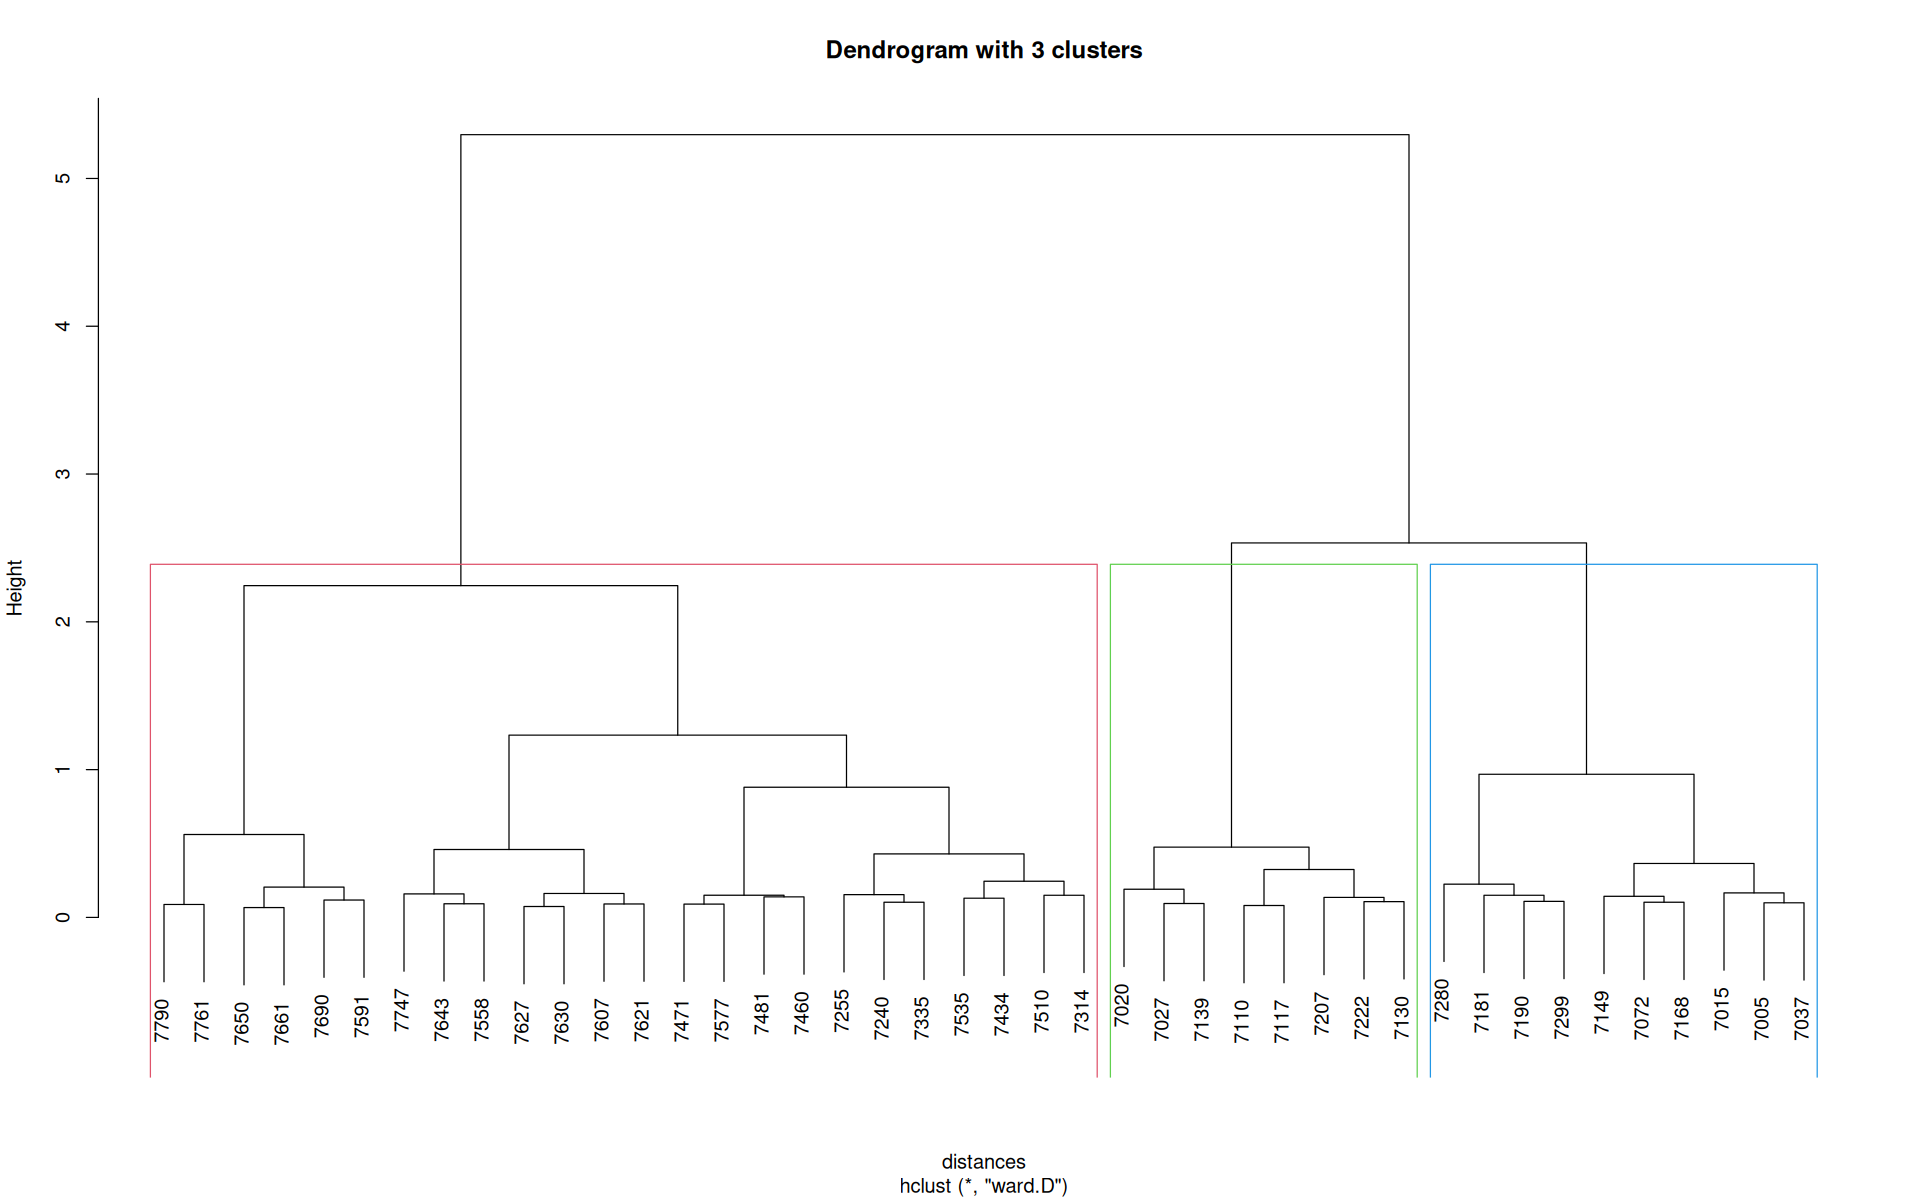

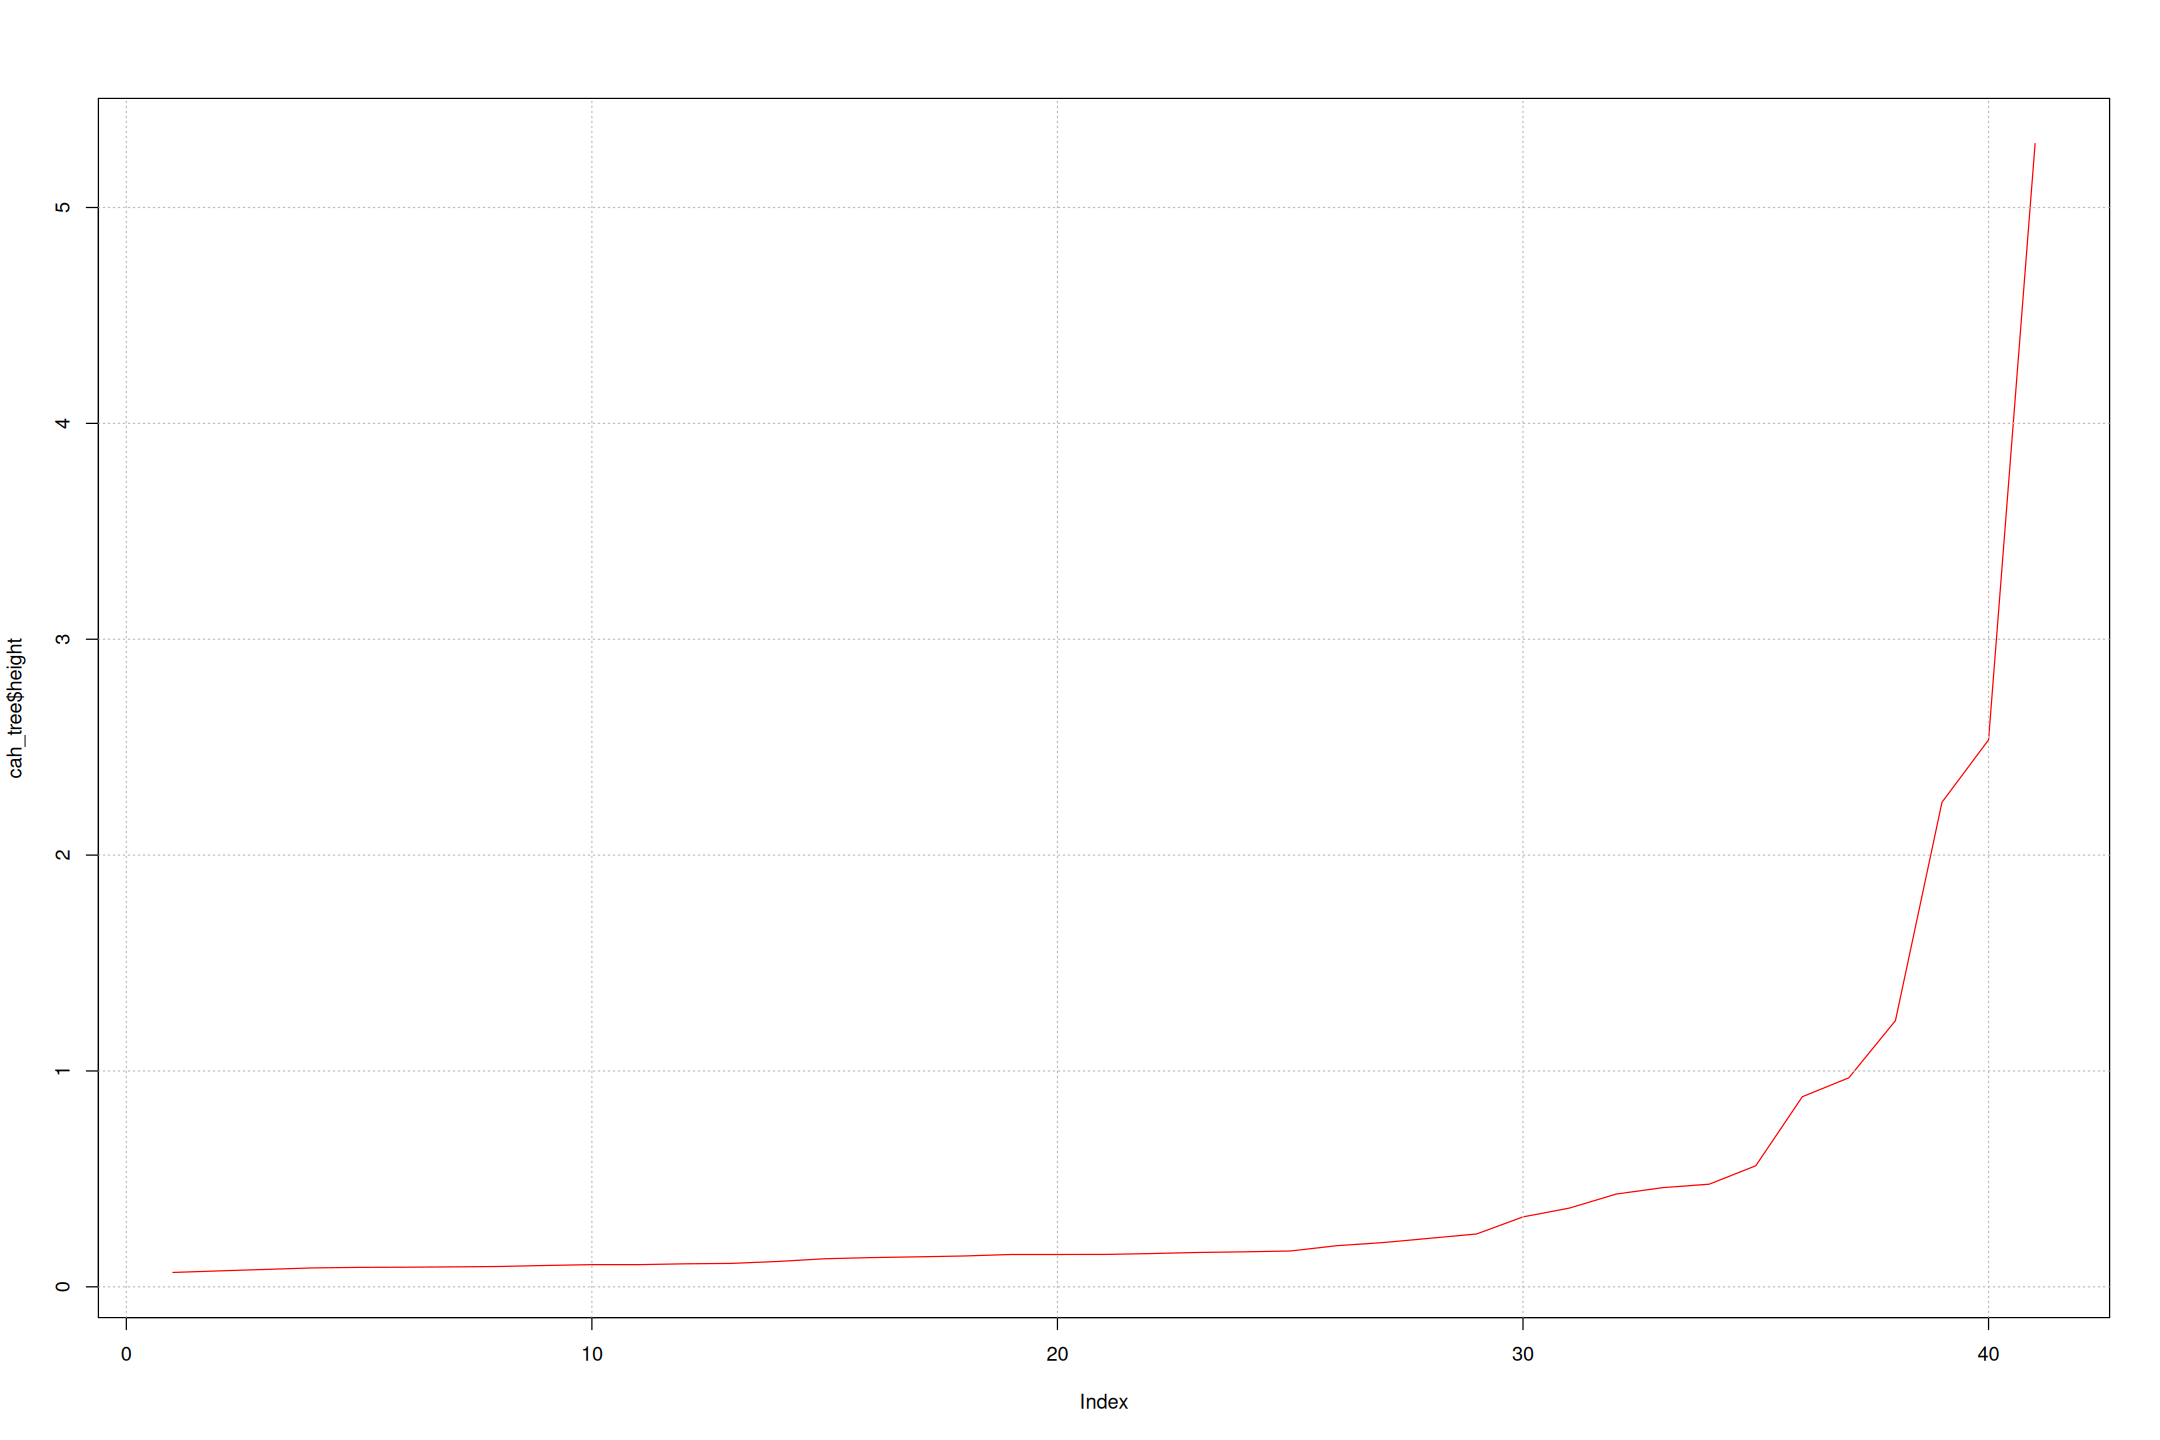

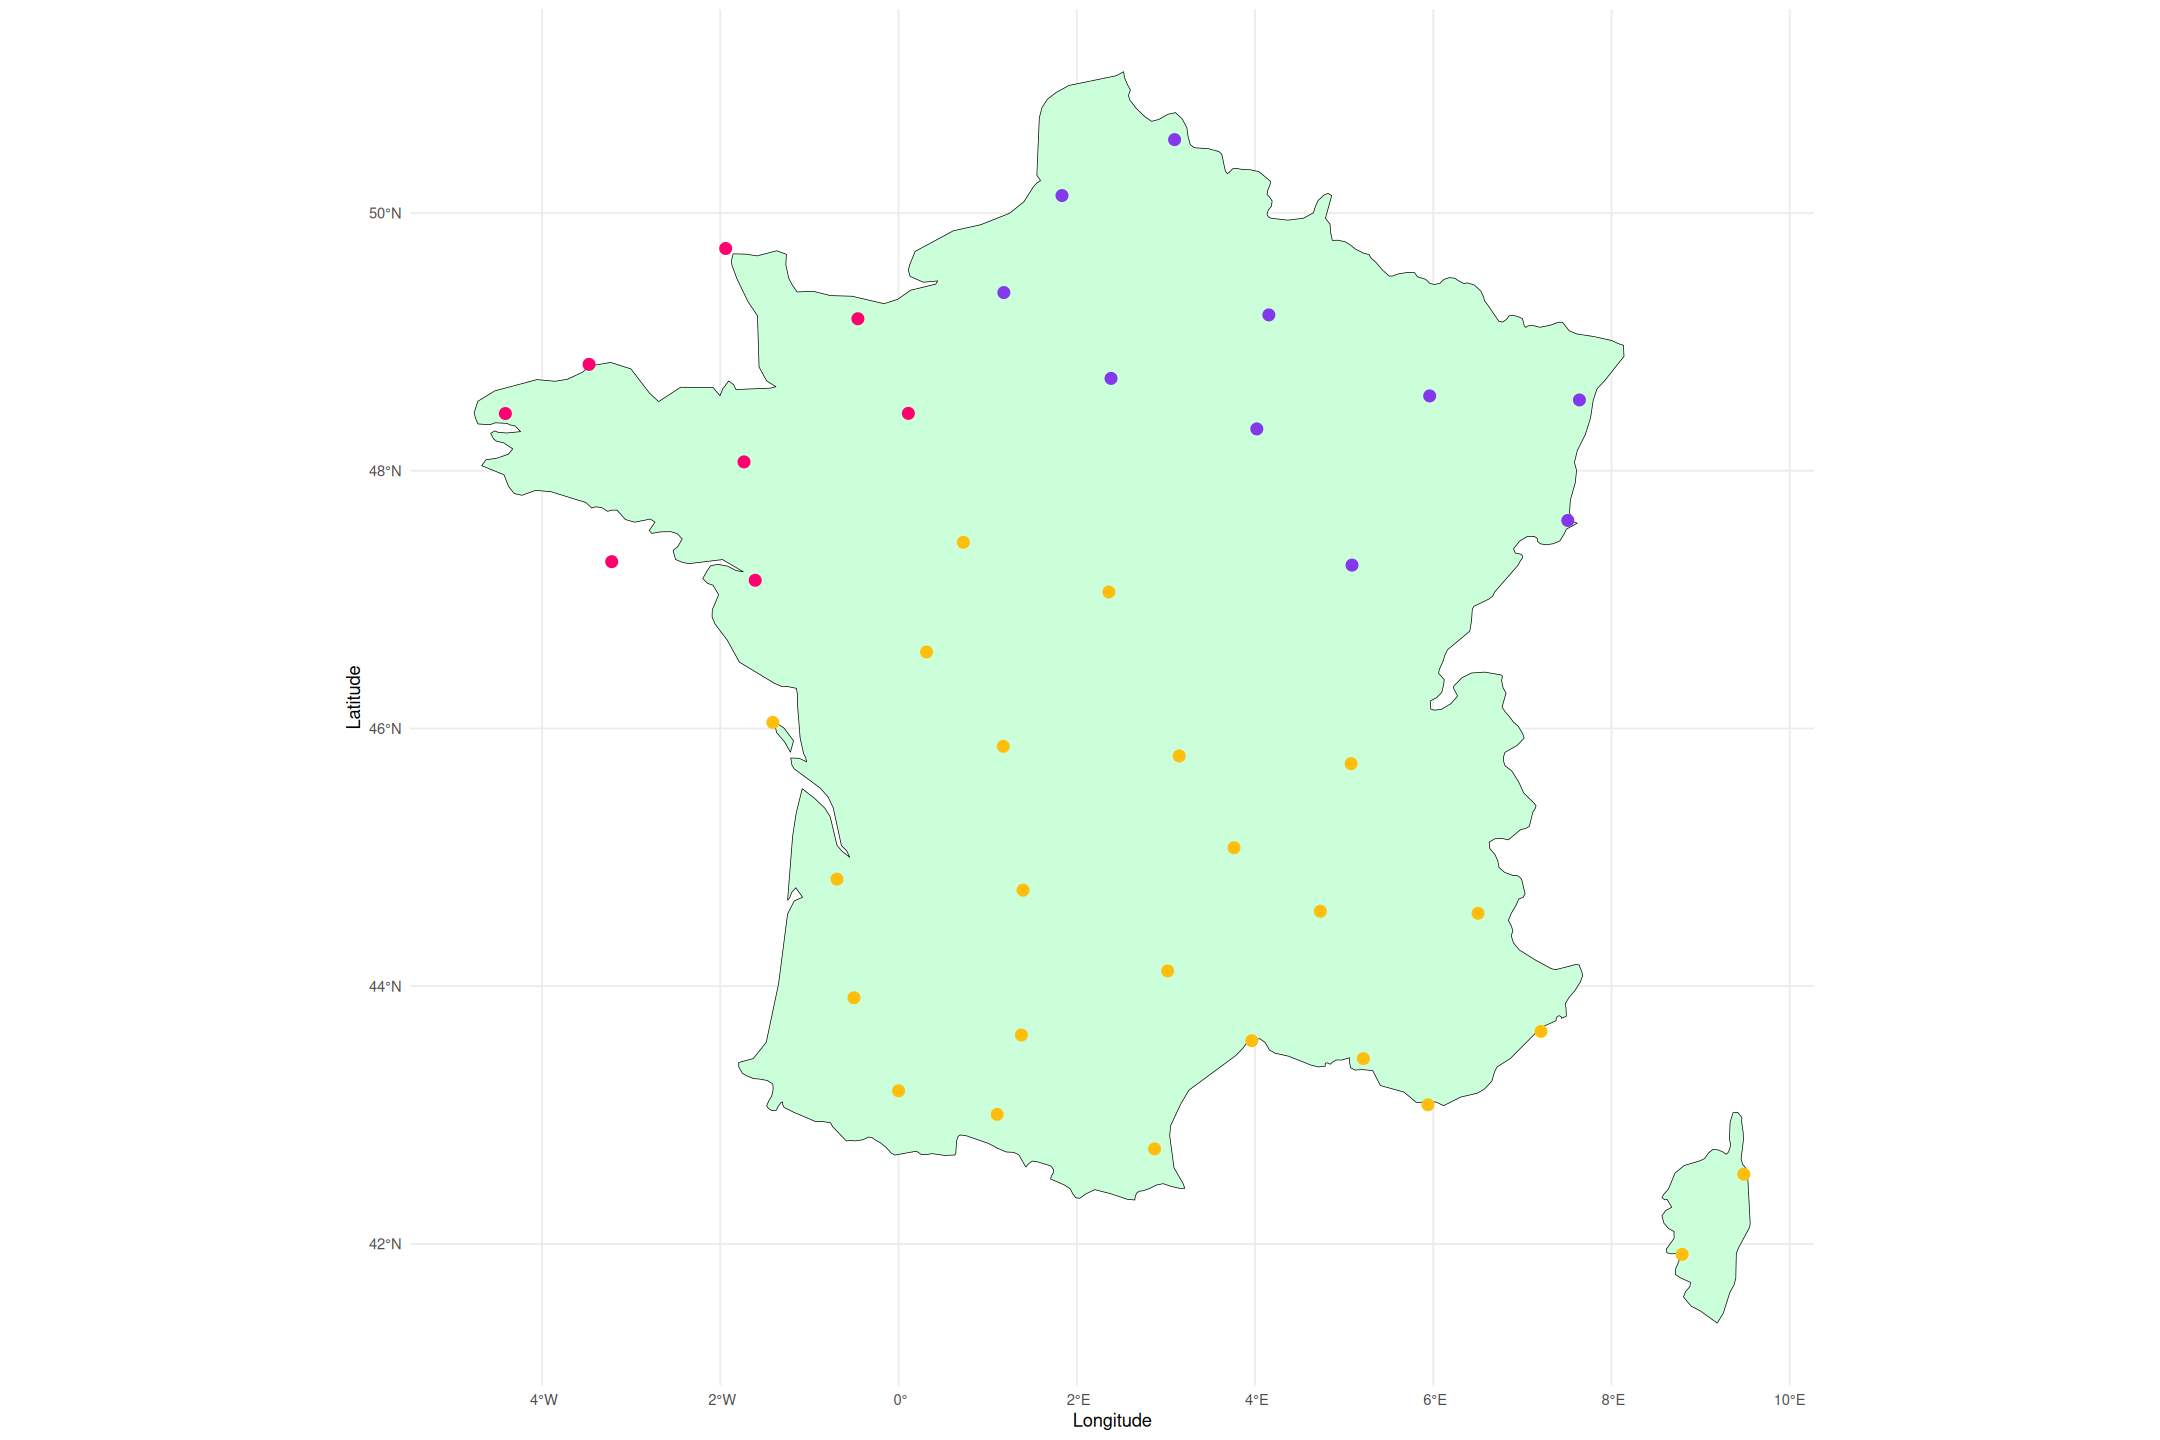

In [84]:
# extract latitudes and longitude
geo_data <- full_data[, c("ID.OMM.station", "Latitude", "Longitude", "Latitude", "Longitude")]
# make it unique
geo_data <- geo_data[!duplicated(geo_data["ID.OMM.station"]), ]

# change names of the second latitude and longitude columns, because we want to use this data 
# for computing distances and auto_dendogram get rid of Lat and Long columns auotmatically
colnames(geo_data) = c("ID.OMM.station", "Latitude", "Longitude", "LatitudeMesure", "LongitudeMesure")

# replace names of rows by station id
row.names(geo_data) <- geo_data$ID.OMM.station
# and delete column
geo_data <- geo_data[, -which(names(geo_data) == "ID.OMM.station")]

# display dendogram and map
auto_dendogram(geo_data, nk=3, metro=metro)

## Critère : Température

In [85]:
# extract two columns temperatures for each station
temperature_data <- full_data[, c("ID.OMM.station", "Température...C.", "Température...C.", "mois_de_l_annee", "Latitude", "Longitude")]
colnames(temperature_data) = c("ID.OMM.station", "TempératureMin", "TempératureMax", "Mois", "Latitude", "Longitude")

# group temperatures by month and station, and take min and max for each month
temperature_monthly_data <- temperature_data %>% 
                    group_by(ID.OMM.station, Mois) %>% 
                    summarise(TempératureMin = min(TempératureMin, na.rm = TRUE),
                                TempératureMax = max(TempératureMax, na.rm = TRUE),
                                Latitude = min(Latitude, na.rm = TRUE),
                                Longitude = min(Longitude, na.rm = TRUE))

# group temperatures by station, min and max temperatures averaged on months
temperature_monthly_avg_data <- temperature_monthly_data %>% 
                    group_by(ID.OMM.station) %>% 
                    summarise(TempératureMinMoy = mean(TempératureMin, na.rm = TRUE),
                                TempératureMaxMoy = mean(TempératureMax, na.rm = TRUE),
                                Latitude = min(Latitude, na.rm = TRUE),
                                Longitude = min(Longitude, na.rm = TRUE))

# change row names to station nameds
temperature_monthly_avg_data <- as.data.frame(temperature_monthly_avg_data)
row.names(temperature_monthly_avg_data) <- temperature_monthly_avg_data$ID.OMM.station
# drop first column
temperature_monthly_avg_data <- temperature_monthly_avg_data[, -which(names(temperature_monthly_avg_data) == "ID.OMM.station")]


`summarise()` has grouped output by 'ID.OMM.station'. You can override using
the `.groups` argument.


     TempératureMinMoy TempératureMaxMoy Latitude Longitude
7005         0.3658863         0.4654341 50.13600  1.834000
7015         0.3732441         0.5064309 50.57000  3.097500
7020         0.6795987         0.0000000 49.72517 -1.939833
7027         0.3505017         0.5048232 49.18000 -0.456167
7037         0.3117057         0.4943730 49.38300  1.181667
7072         0.1170569         0.5594855 49.20967  4.155333
7110         0.4120401         0.4662379 48.44417 -4.412000
7117         0.7063545         0.3223473 48.82583 -3.473167
7130         0.3939799         0.6109325 48.06883 -1.734000
7139         0.2735786         0.5064309 48.44550  0.110167
7149         0.3879599         0.6205788 48.71683  2.384333
7168         0.2026756         0.6591640 48.32467  4.020000
7181         0.1826087         0.5594855 48.58100  5.959833
7190         0.2381271         0.6760450 48.54950  7.640333
7207         0.7190635         0.2049839 47.29433 -3.218333
7222         0.4140468         0.6840836

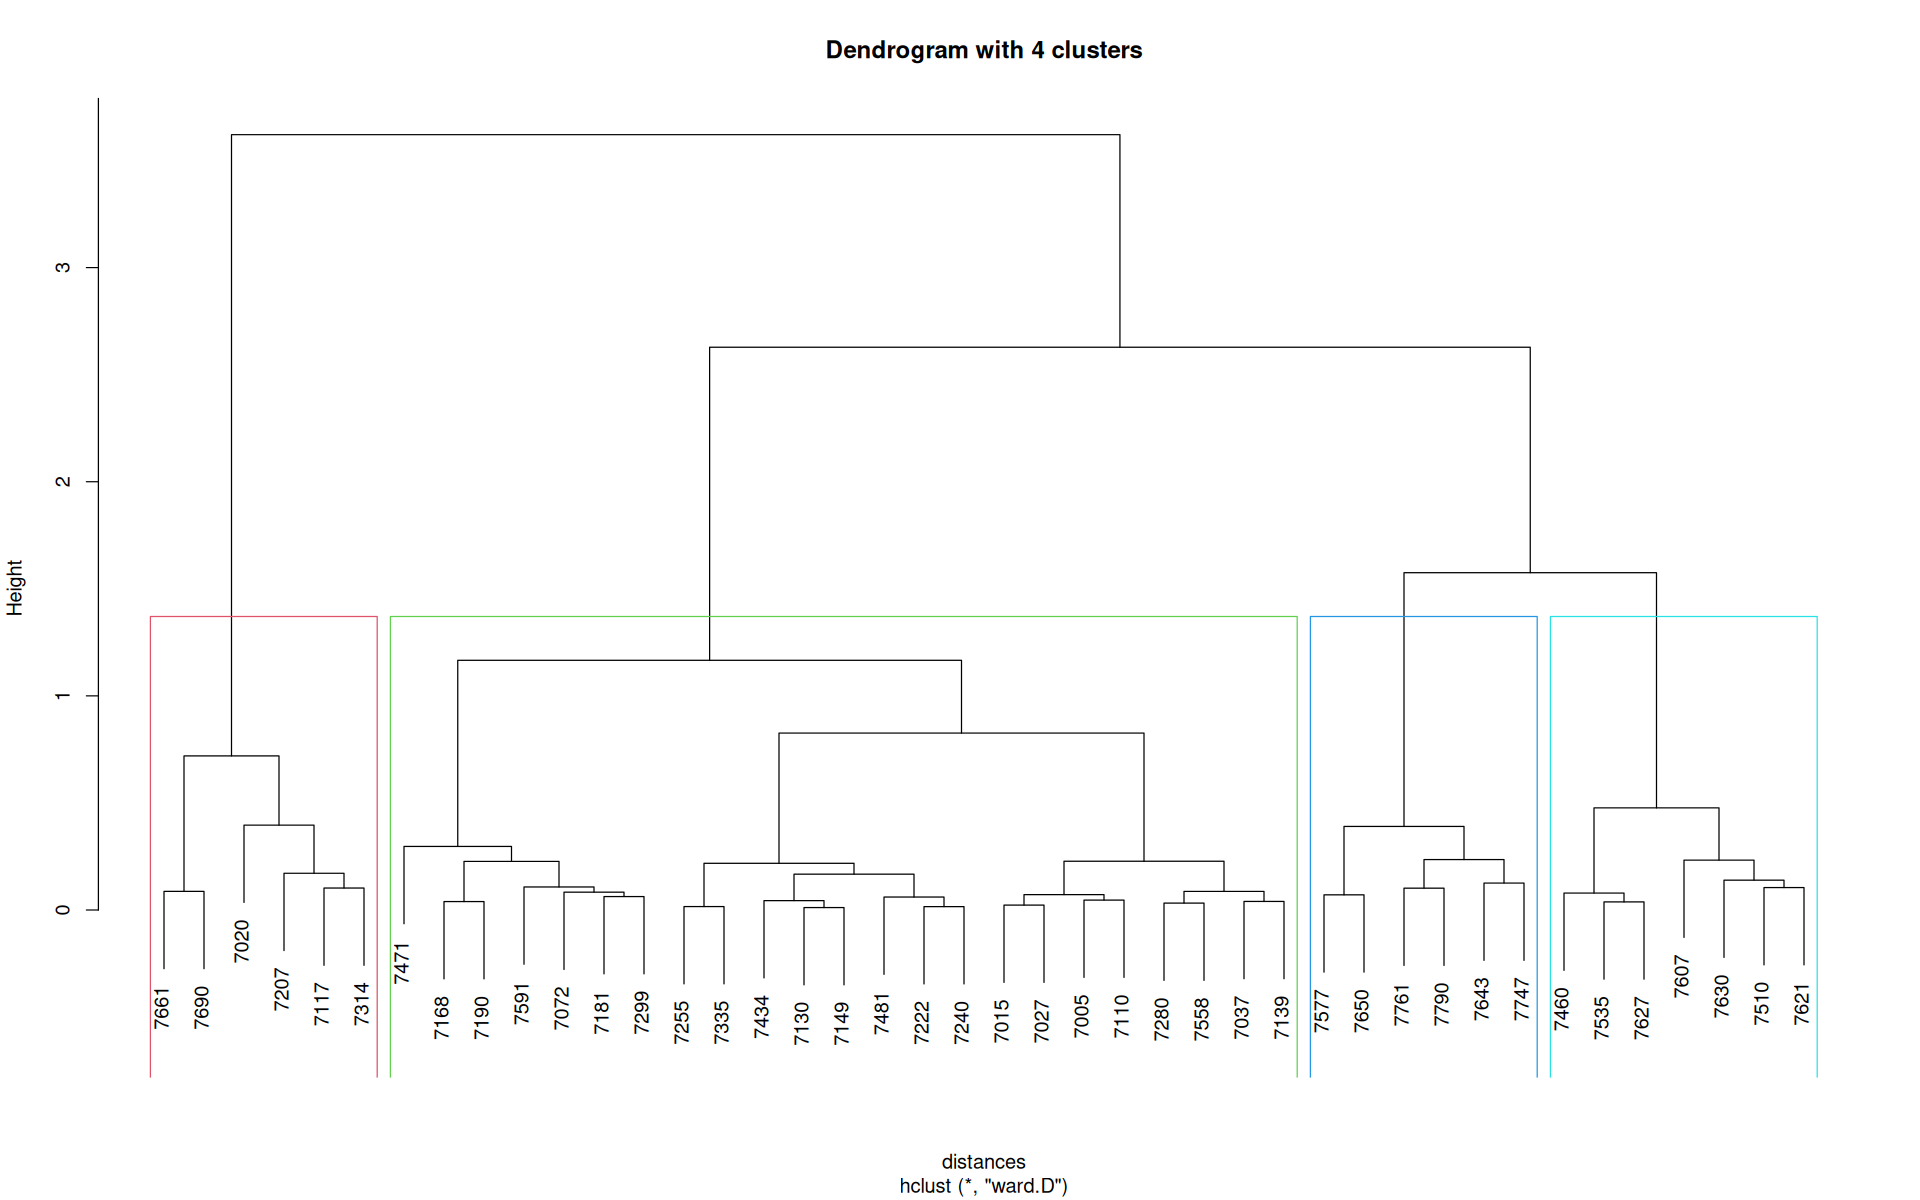

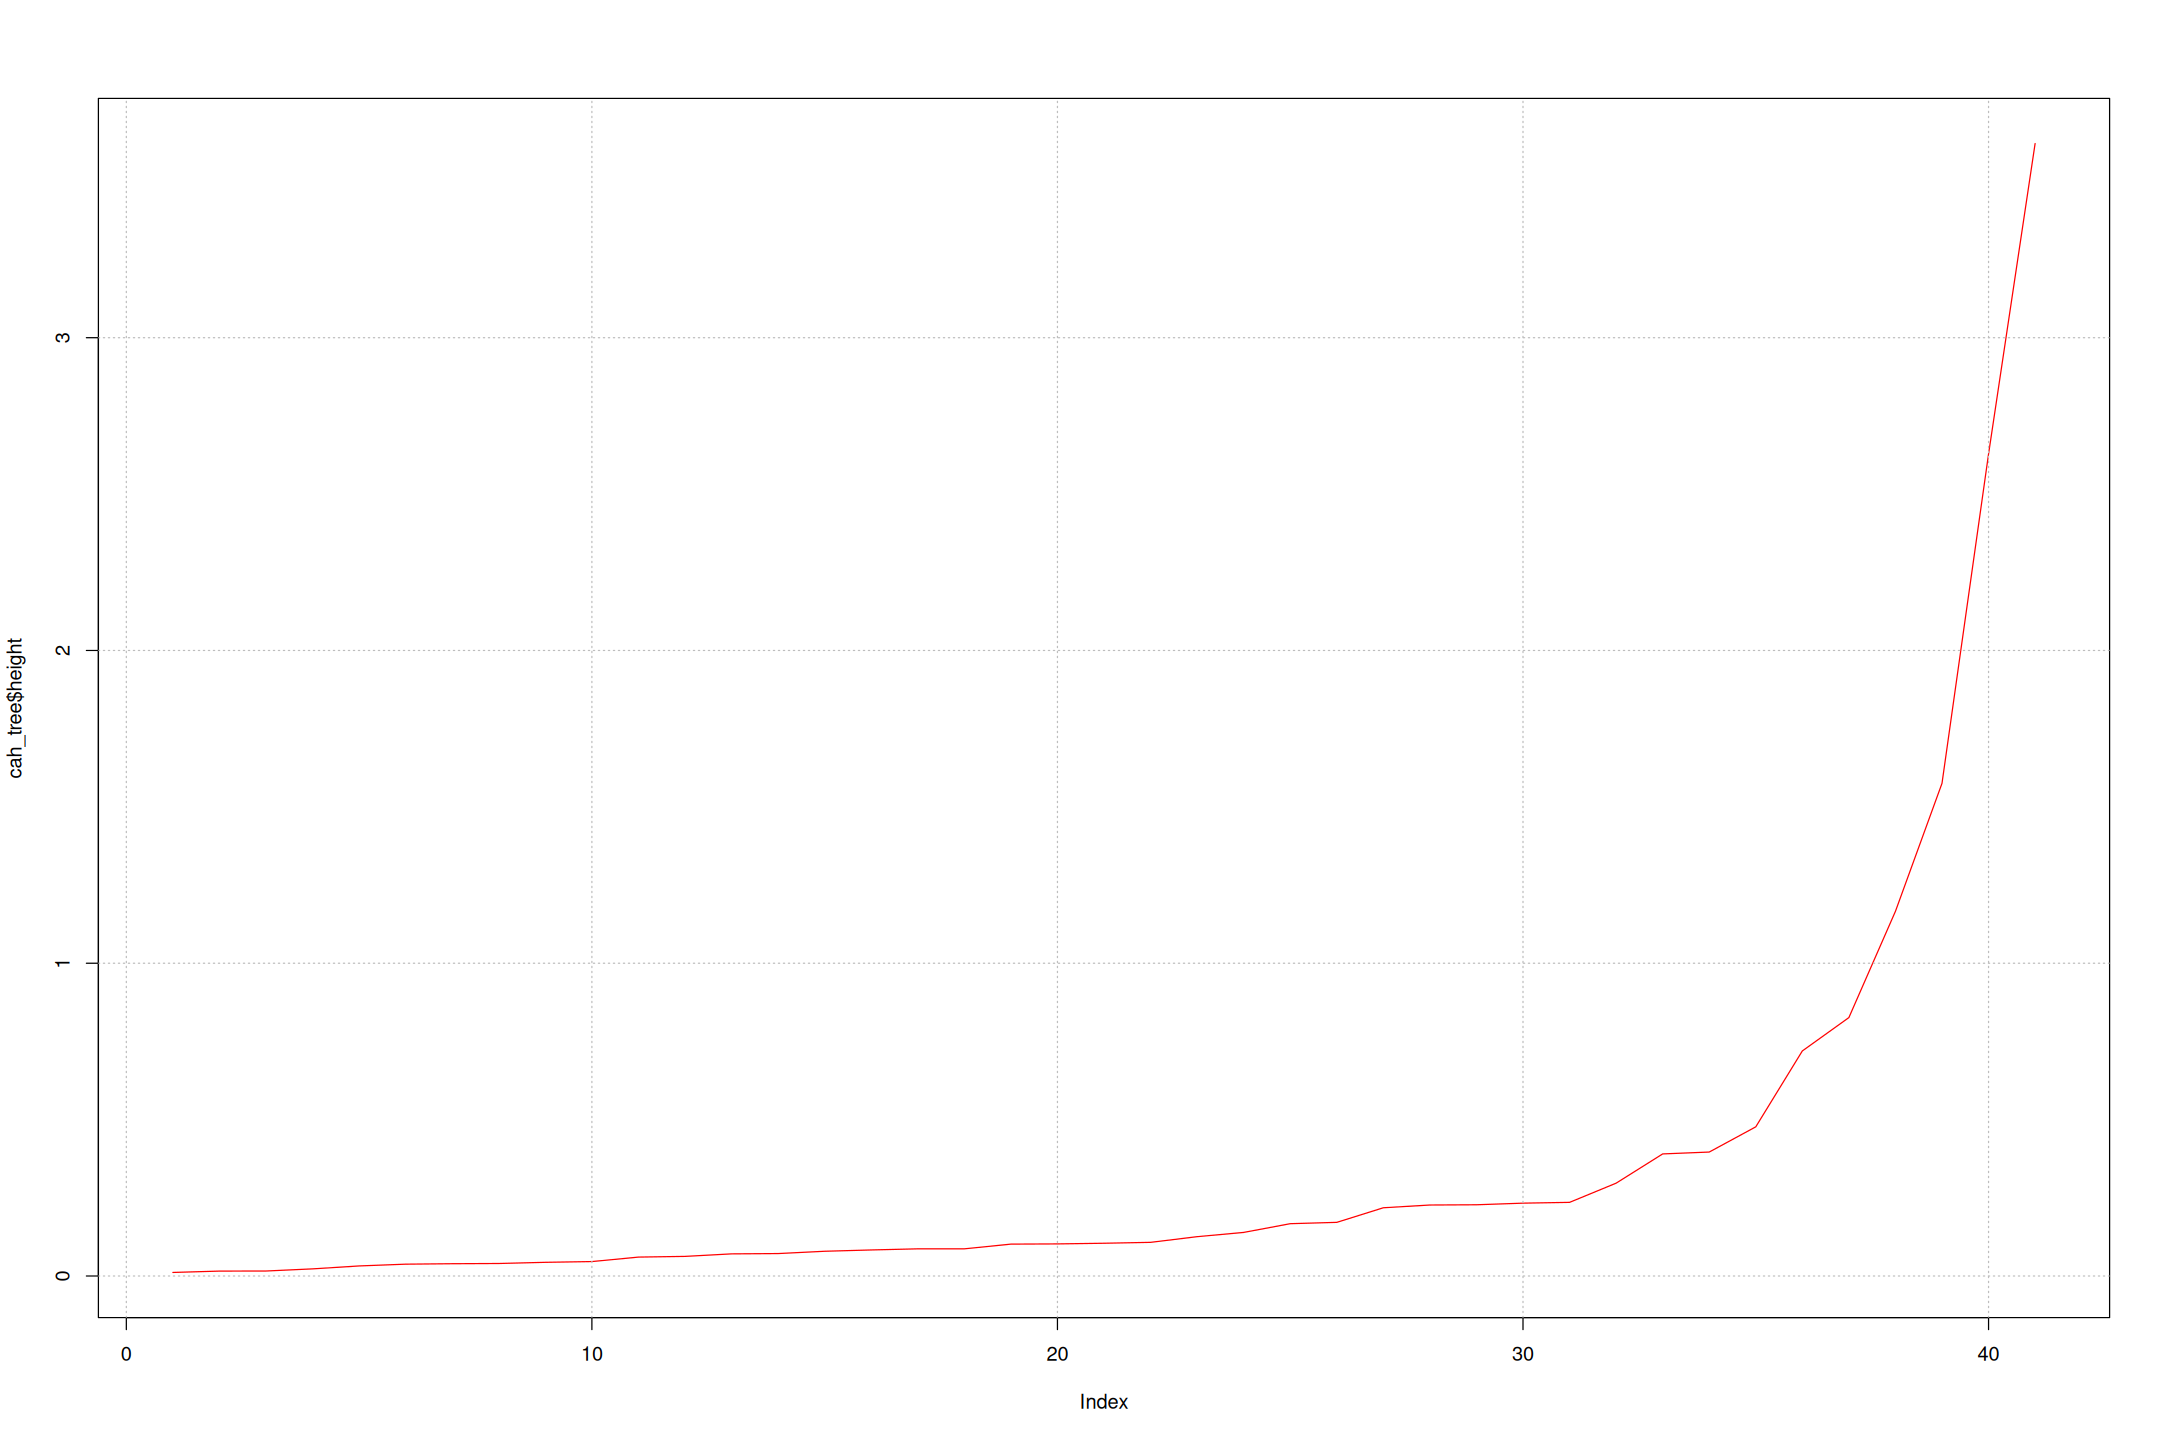

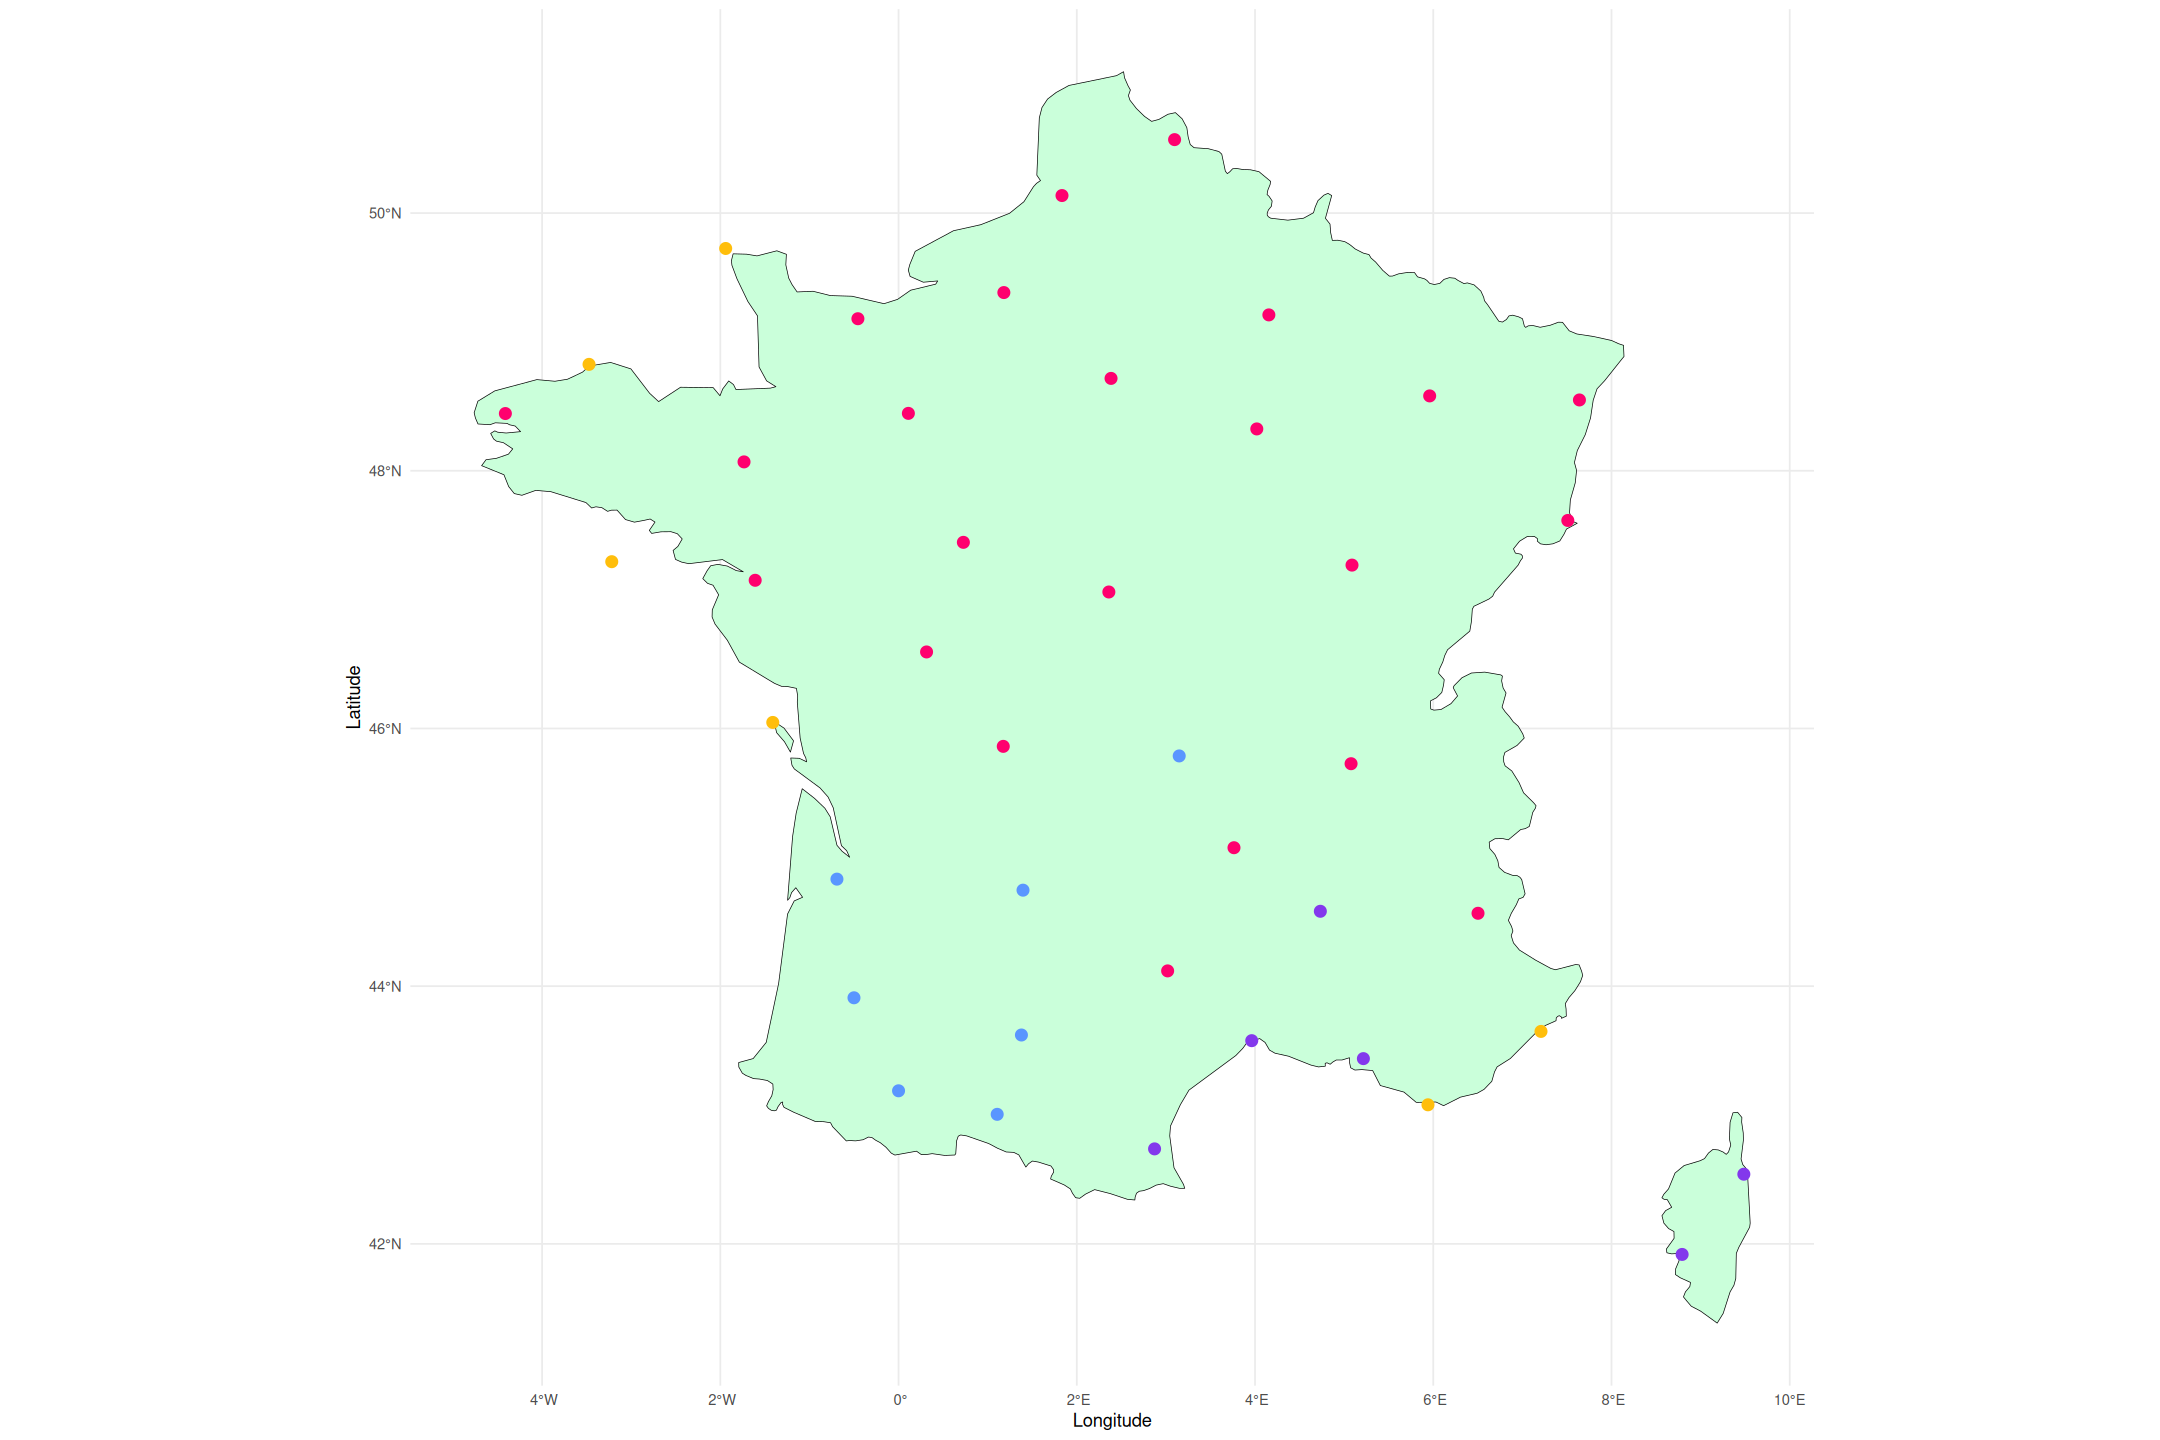

In [86]:
# display dendogram and map
auto_dendogram(temperature_monthly_avg_data, nk=4, metro=metro)

## Critère : Nébulosité, pression, Tmin et Tmax moyen par jour

In [87]:
# extract two columns temperatures for each station
TNP_data <- full_data[, c("ID.OMM.station", "Température...C.", "Température...C.", "mois_de_l_annee", "Pression.station", "Nebulosité.totale", "Latitude", "Longitude")]
colnames(TNP_data) = c("ID.OMM.station", "TempératureMin", "TempératureMax", "Mois", "Pression.station", "Nebulosité.totale", "Latitude", "Longitude")

# group temperatures by month and station, and take min and max for each month
TNP_monthly_data <- TNP_data %>% 
                    group_by(ID.OMM.station, Mois) %>% 
                    summarise(TempératureMin = min(TempératureMin, na.rm = TRUE),
                                TempératureMax = max(TempératureMax, na.rm = TRUE),
                                PressionMoy = mean(Pression.station, na.rm=TRUE),
                                NebulositeMoy = mean(Nebulosité.totale, na.rm=TRUE),
                                Latitude = min(Latitude, na.rm = TRUE),
                                Longitude = min(Longitude, na.rm = TRUE))

# change format of dataframe : each column is duplicated (on column per data per month (yearly))
TNP_wide <- TNP_monthly_data %>%
  pivot_wider(
    id_cols = c(ID.OMM.station, Latitude, Longitude),
    names_from = Mois,
    values_from = c(TempératureMin, TempératureMax, PressionMoy, NebulositeMoy),
    names_sep = "_",
    names_glue = "{.value}_month{Mois}"
  )

# change row names to station nameds
TNP_wide <- as.data.frame(TNP_wide)
row.names(TNP_wide) <- TNP_wide$ID.OMM.station
# drop first column
TNP_wide <- TNP_wide[, -which(names(TNP_wide) == "ID.OMM.station")]

print(TNP_wide)



`summarise()` has grouped output by 'ID.OMM.station'. You can override using
the `.groups` argument.


     Latitude Longitude TempératureMin_month1 TempératureMin_month2
7005 50.13600  1.834000                  -7.4                  -7.5
7015 50.57000  3.097500                  -7.2                  -7.5
7020 49.72517 -1.939833                  -3.1                  -2.7
7027 49.18000 -0.456167                  -6.5                  -6.7
7037 49.38300  1.181667                  -6.5                  -9.0
7072 49.20967  4.155333                 -10.2                 -10.6
7110 48.44417 -4.412000                  -4.3                  -6.5
7117 48.82583 -3.473167                  -3.0                  -4.3
7130 48.06883 -1.734000                  -6.7                  -6.7
7139 48.44550  0.110167                  -9.4                  -9.2
7149 48.71683  2.384333                  -7.2                  -8.4
7168 48.32467  4.020000                 -11.0                 -10.1
7181 48.58100  5.959833                 -11.5                 -12.0
7190 48.54950  7.640333                 -11.2   

     Latitude Longitude TempératureMin_month1 TempératureMin_month2
7005 50.13600  1.834000            0.37820513             0.5384615
7015 50.57000  3.097500            0.39102564             0.5384615
7020 49.72517 -1.939833            0.65384615             0.8224852
7027 49.18000 -0.456167            0.43589744             0.5857988
7037 49.38300  1.181667            0.43589744             0.4497041
7072 49.20967  4.155333            0.19871795             0.3550296
7110 48.44417 -4.412000            0.57692308             0.5976331
7117 48.82583 -3.473167            0.66025641             0.7278107
7130 48.06883 -1.734000            0.42307692             0.5857988
7139 48.44550  0.110167            0.25000000             0.4378698
7149 48.71683  2.384333            0.39102564             0.4852071
7168 48.32467  4.020000            0.14743590             0.3846154
7181 48.58100  5.959833            0.11538462             0.2721893
7190 48.54950  7.640333            0.13461538   

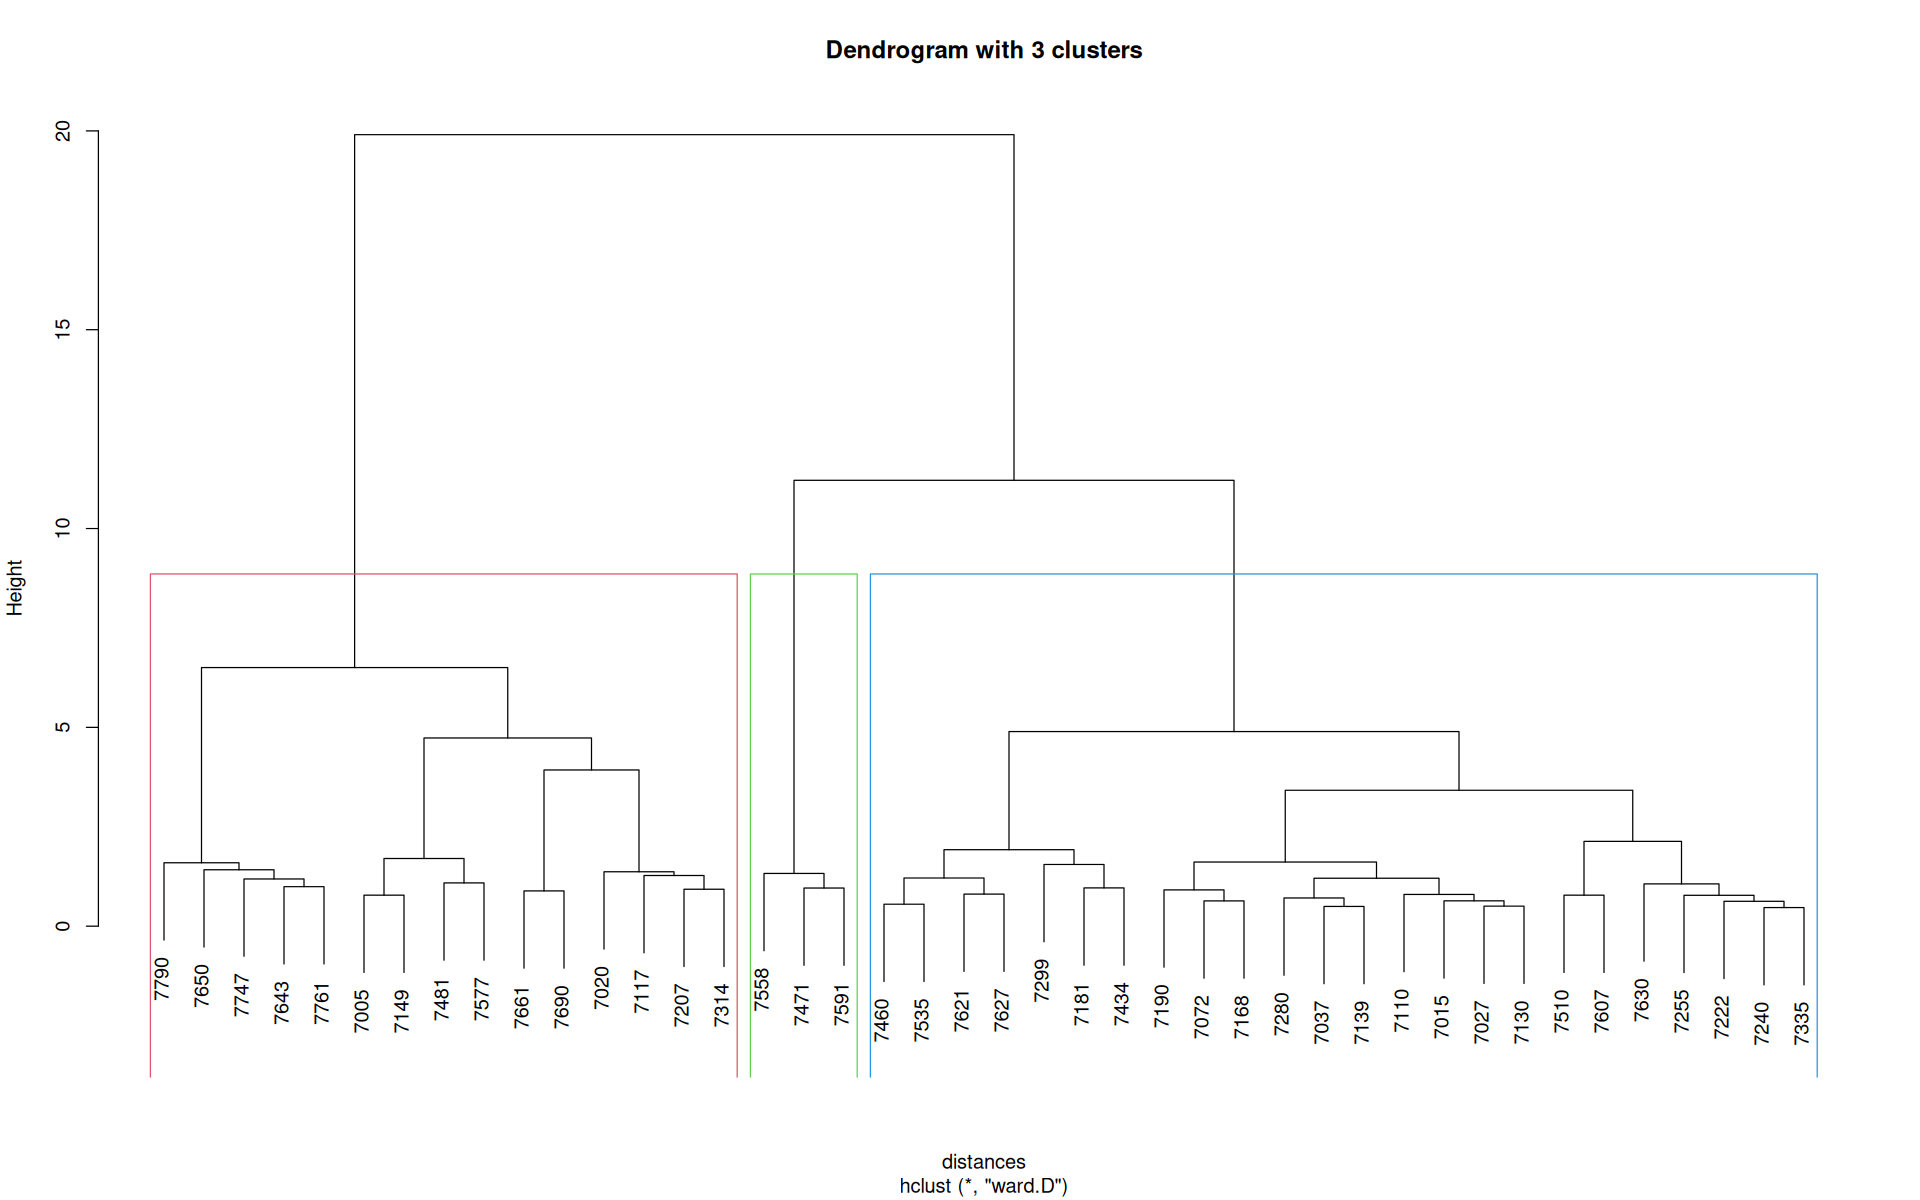

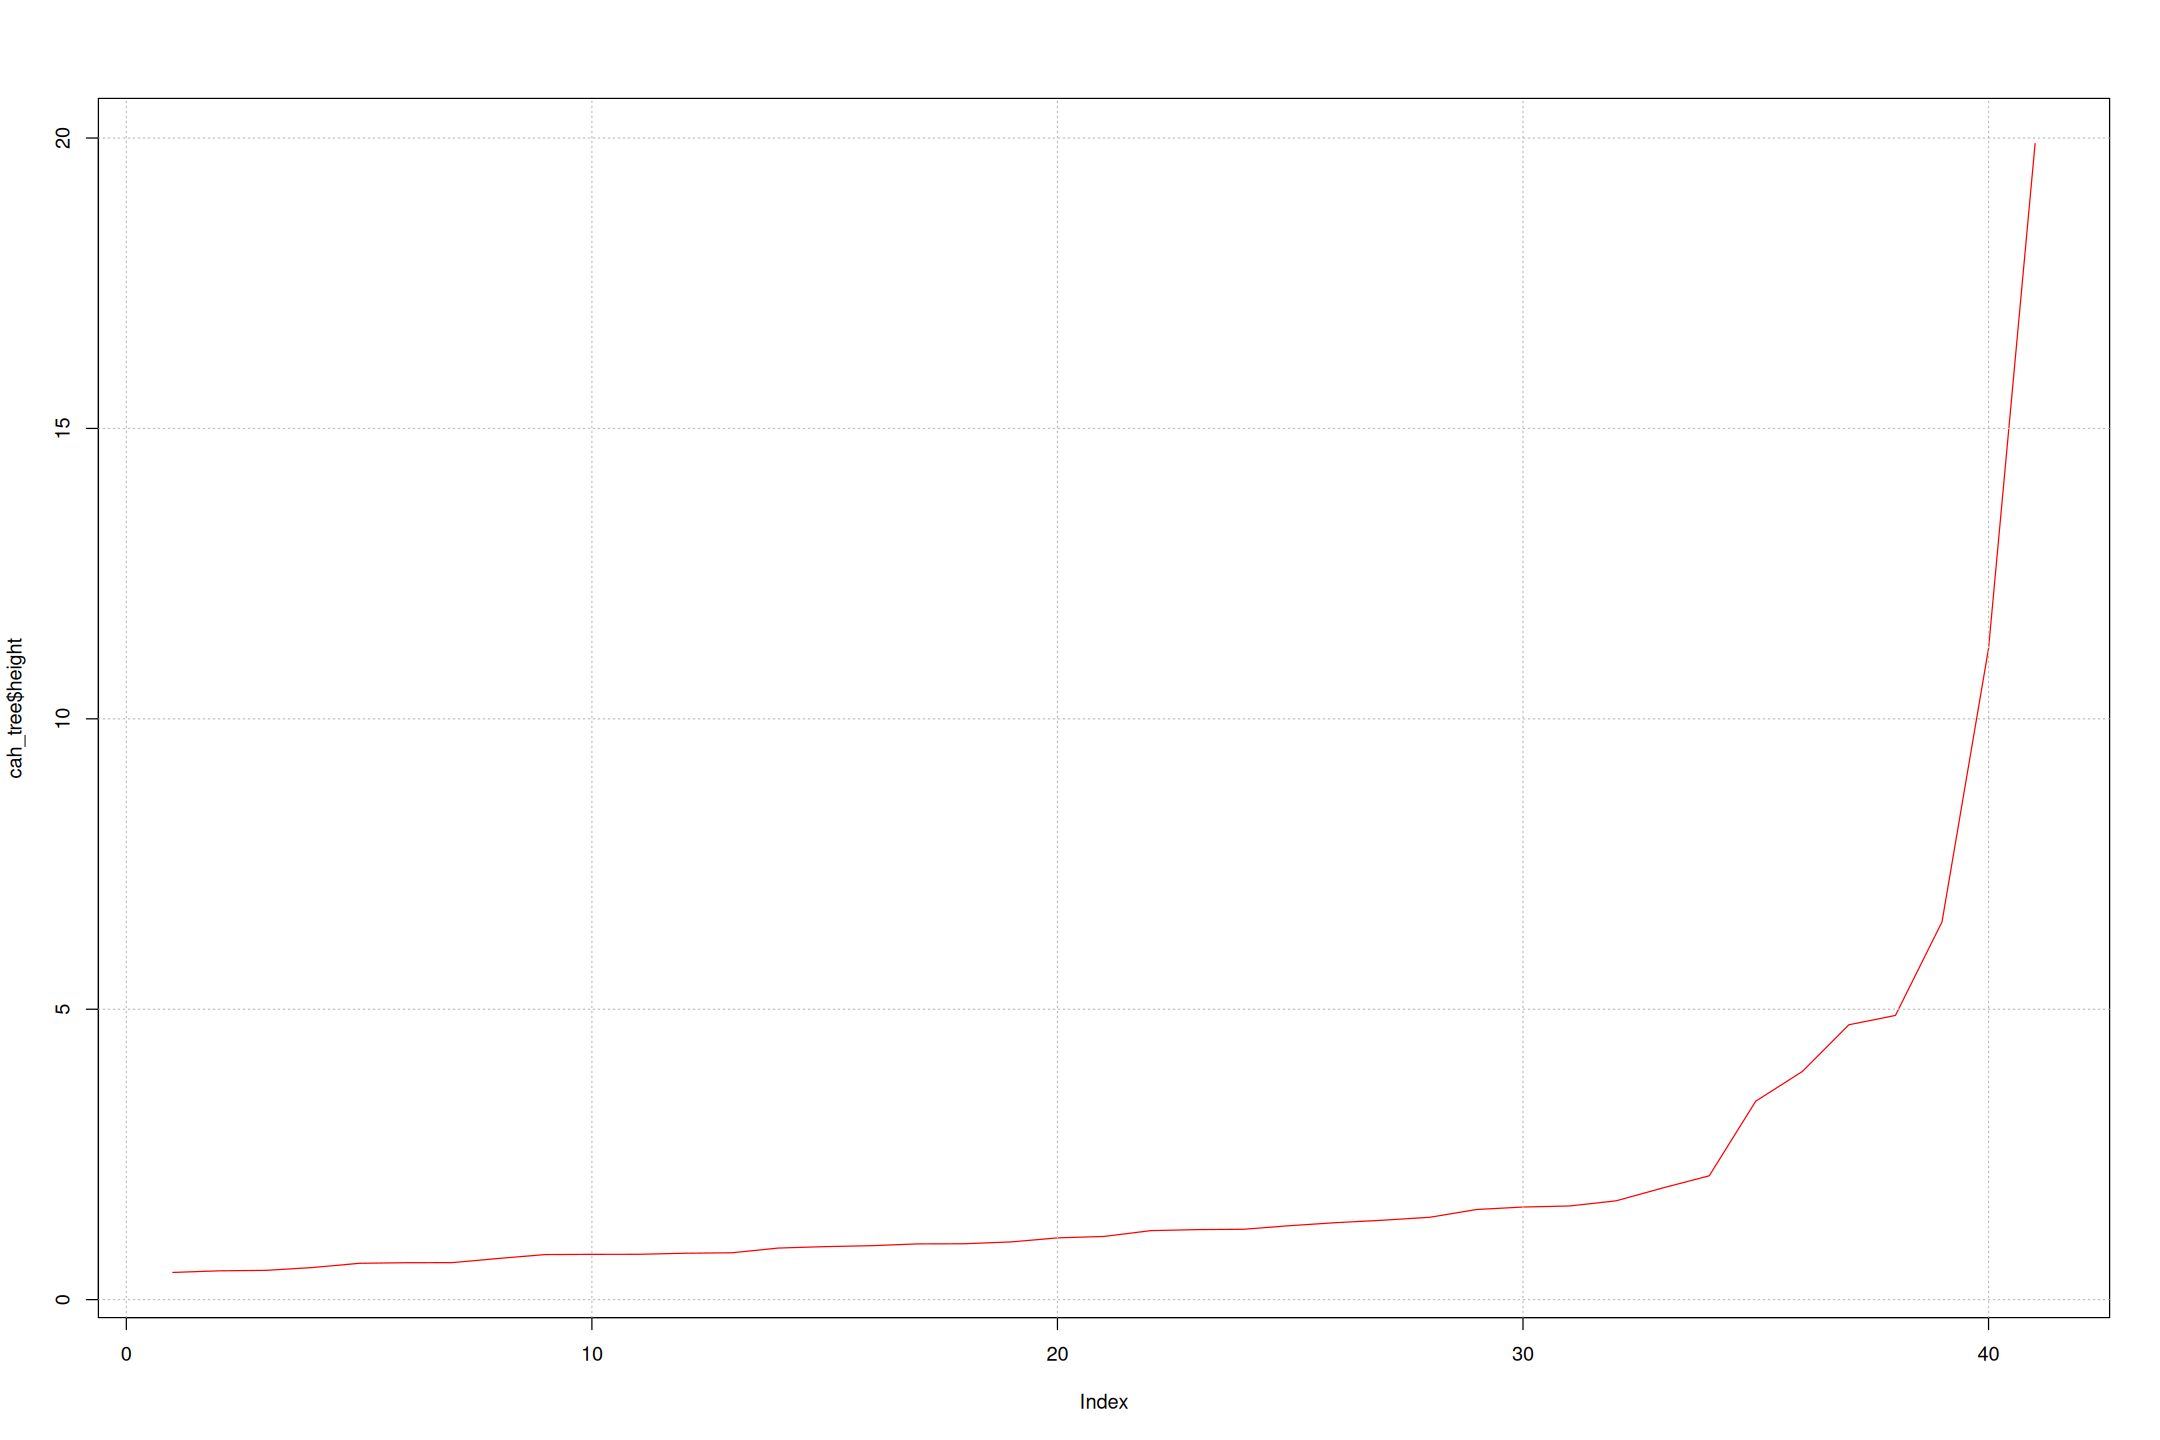

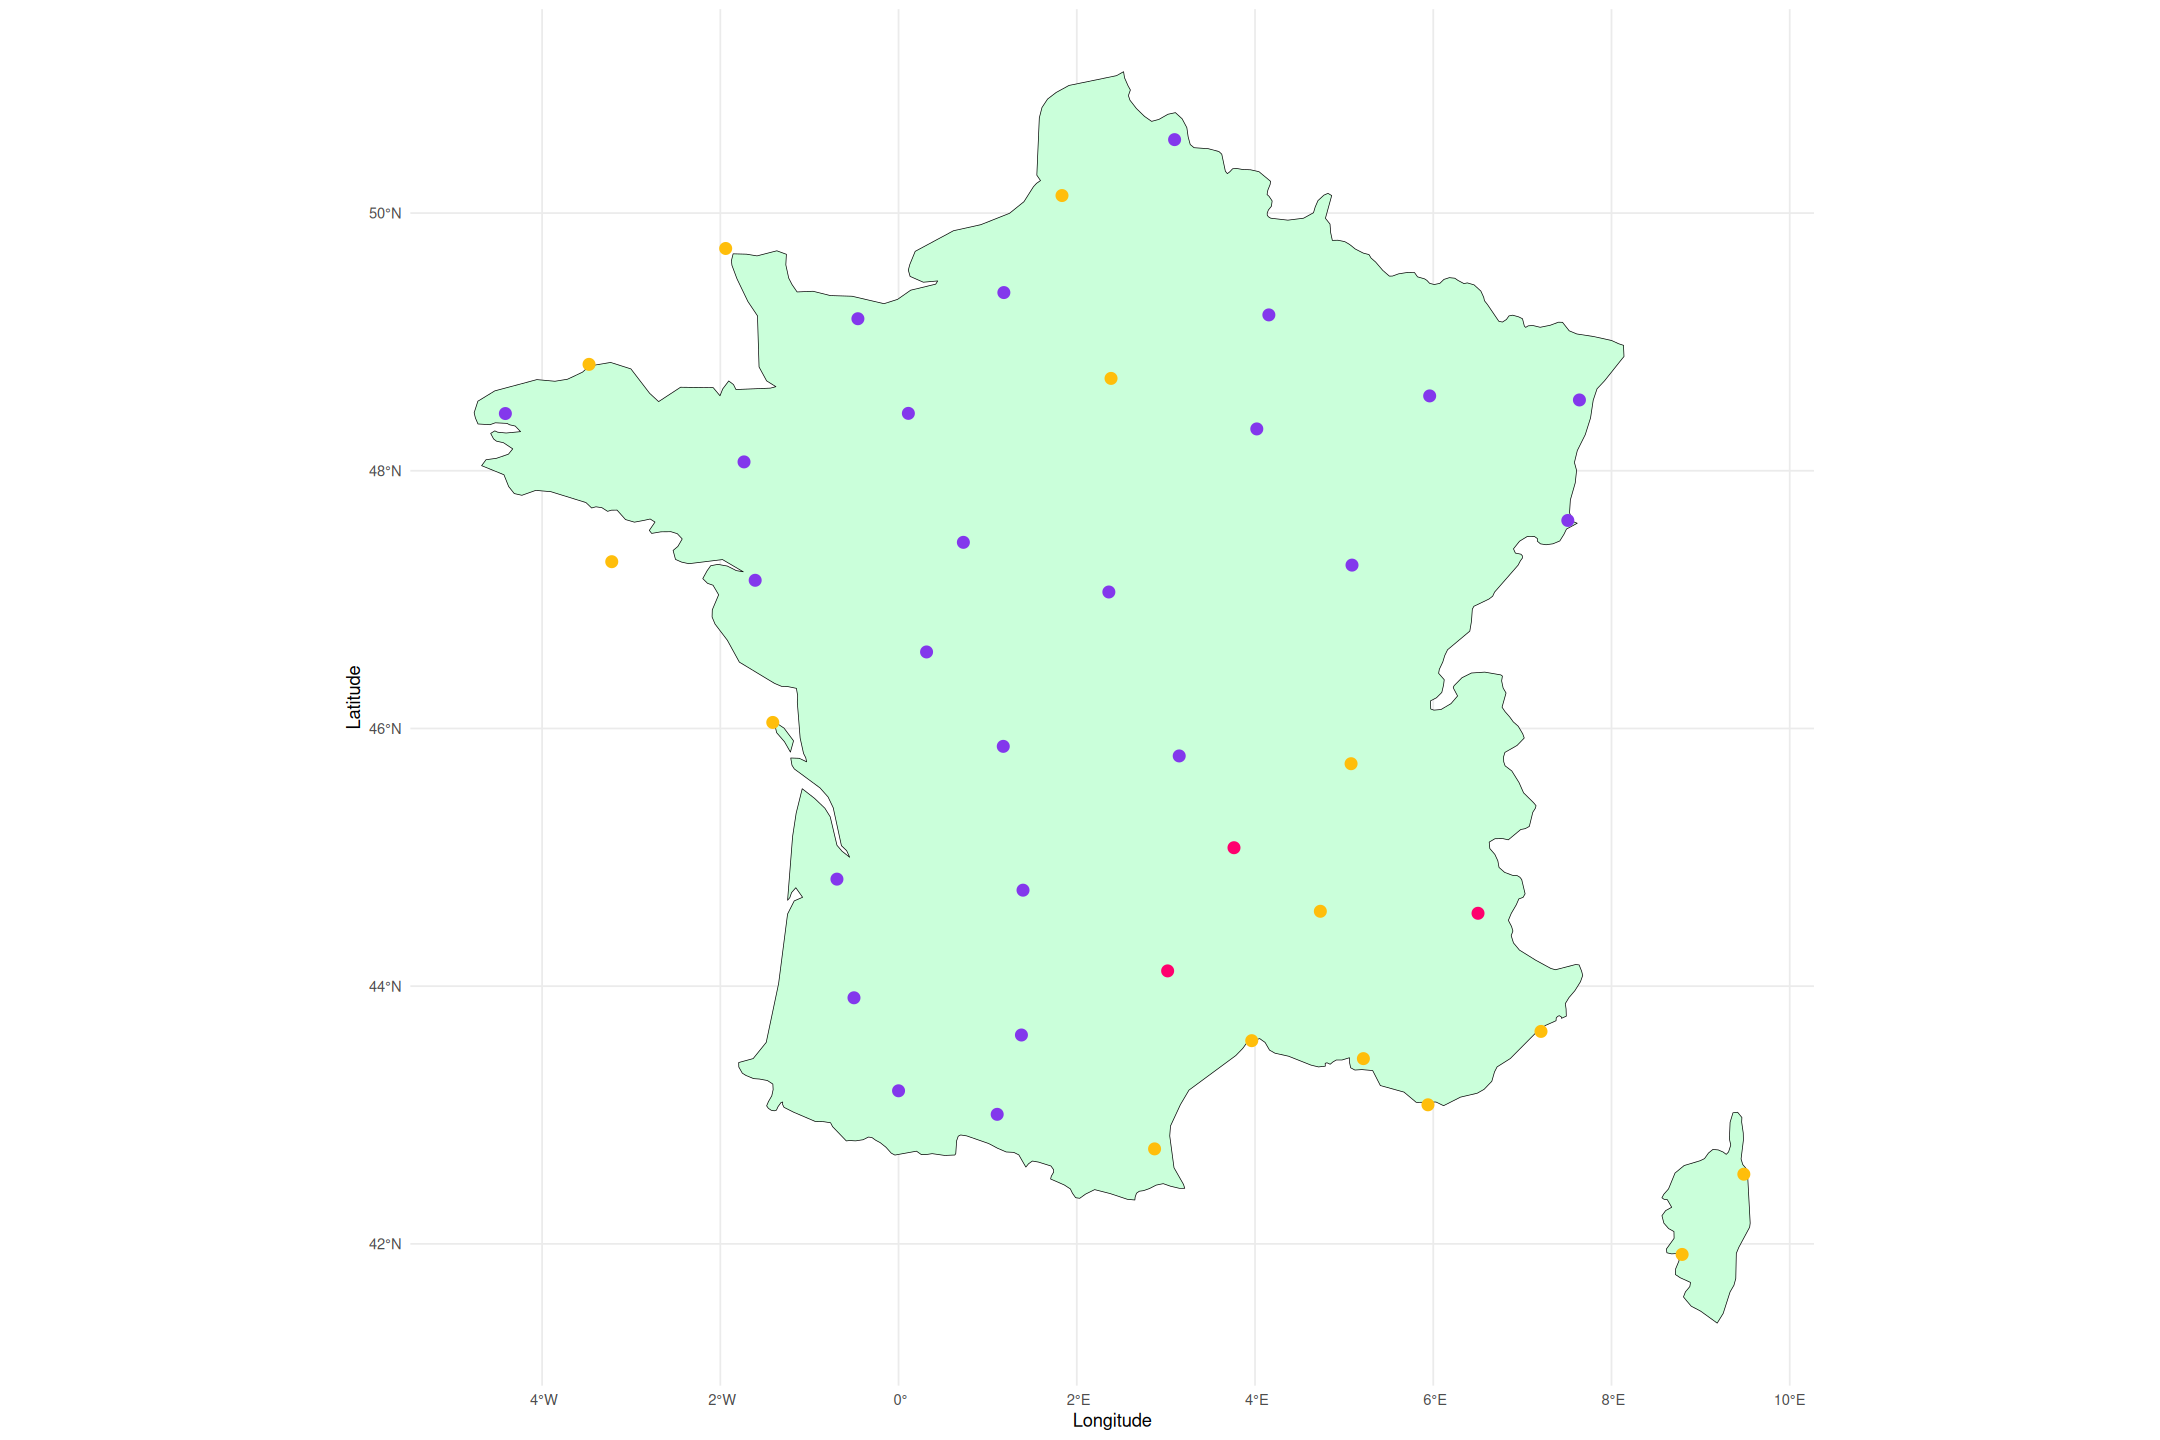

In [88]:
# display dendogram and map
auto_dendogram(TNP_wide, nk=3, metro=metro)